# Explore Denmarks Letters (Danmarks Breve)

## Script Summary

This notebook explores a dataset constructed from the XML sources behind the Royal Danish Library’s digital [`Danmarks Breve`](https://tekster.kb.dk/text?editorial=no&f%5Bsubcollection_ssi%5D%5B%5D=letters&match=one&search_field=Alt) collection, which holds 13,000+ printed letters and metadata.

**Steps:**
- Load the harmonised bibliographic dataset, _Denmarks_letters_dataset.csv_, derived from the XML files and inspect schemas for key entities (`sender_st`, `recipiant_st`, `text_st`, `year_st`).
- Build directed correspondence networks for selected time windows, compute centrality summaries, and visualise letter flows between prominent individuals.
- Aggregate letters per sender and run TF–IDF analysis to surface each sender’s 15 most distinctive words.
- Prepare helper tables (`_top_senders_df`, `sender_tfidf_top_words`) for downstream analysis or export.

**Outputs:** Network statistics/plots, sender-level TF–IDF tables, and dataframes ready for further historical or linguistic study.

**Dataset:** To download the dataset follow go to the [Library's Open Access Repository](https://loar.kb.dk/handle/1902/49123).

**Digital Collection:** To close read the letters in Denmarks Letters go to the [Letter Collection](https://loar.kb.dk/handle/1902/49123). 

---

In [1]:
# Core libraries and configuration
import pandas as pd
import warnings

# Network analysis and plotting
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Suppress sklearn stop-word warnings triggered by OCR artefacts
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_extraction.text')


Load the dataset and inspect the shape, the columns, and the datatypes of the dataset.

In [2]:
# Read the data
dk_letters_st = pd.read_csv('Denmarks_letters_dataset.csv')

In [3]:
# Inspect the shape of the dataset
dk_letters_st.shape

(13516, 20)

In [4]:
# Inspect available columns
dk_letters_st.columns

Index(['url', 'sender', 'sender_st', 'recipiant', 'recipiant_st', 'geo_name',
       'raw_date', 'raw_text', 'year_st', 'text_st', 'word_count',
       'geo_name_st', 'xml_file_name', 'pubTitle', 'pubAuthor', 'pubPublisher',
       'pubPublisher_st', 'pubPlace', 'pubPlace_st', 'pubDate'],
      dtype='object')

In [5]:
# Review column data types
dk_letters_st.dtypes

url                 object
sender              object
sender_st           object
recipiant           object
recipiant_st        object
geo_name            object
raw_date            object
raw_text            object
year_st            float64
text_st             object
word_count           int64
geo_name_st         object
xml_file_name       object
pubTitle            object
pubAuthor           object
pubPublisher        object
pubPublisher_st     object
pubPlace            object
pubPlace_st         object
pubDate             object
dtype: object

## Filter and Subset the Data

Rows with missing values in the sender or recipient columns are filtered out. A subset of the data is created by selecting rows within a specific time period (1870-1885).


In [6]:
# Filter out rows with NaN in sender or recipient columns
dk_letters_filtered = dk_letters_st.dropna(subset=['sender_st', 'recipiant_st'])

# Create a subset of the data by selecting rows with values between two years
_from = 1870
_to = 1885
dk_letters_subset = dk_letters_filtered.query(f'year_st > {_from} and year_st < {_to}')

# Inspect the shape of the subset
dk_letters_subset.shape

(1236, 20)

## Who wrote to whom? Network analysis with NetworkX

First we filter the dataset to a specific period and build a directed graph where edges connect senders to recipients. We then inspect degree-based rankings and visualise the full network as well as a view of the top correspondents before moving into TF–IDF vocabulary analysis.

In [7]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from sender to recipient
for _, row in dk_letters_subset.iterrows():
    sender = row['sender_st']
    recipient = row['recipiant_st']
    
    # Add edge (if edge already exists, weight will be incremented)
    if G.has_edge(sender, recipient):
        G[sender][recipient]['weight'] += 1
    else:
        G.add_edge(sender, recipient, weight=1)

print(f"Network has {G.number_of_nodes()} nodes (people) and {G.number_of_edges()} edges (letter connections)")


Network has 186 nodes (people) and 226 edges (letter connections)


In [8]:
# Basic network statistics
print("Network Statistics:")
print(f"Number of nodes (people): {G.number_of_nodes()}")
print(f"Number of edges (letter connections): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Top senders (out-degree)
top_senders = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Senders:")
for person, count in top_senders:
    print(f"  {person}: {count} letters sent")

# Top recipients (in-degree)
top_recipients = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Recipients:")
for person, count in top_recipients:
    print(f"  {person}: {count} letters received")


Network Statistics:
Number of nodes (people): 186
Number of edges (letter connections): 226
Network density: 0.0066

Top 10 Senders:
  Lange, Julius Henrik: 31 letters sent
  Zahrtmann, Kristian: 20 letters sent
  Laub, Hardenack Otto Conrad: 17 letters sent
  Rosenørn-Lehn, Otto Ditlev: 10 letters sent
  Birkeland, Michael: 10 letters sent
  Hegel, Frederik Vilhelm: 6 letters sent
  Drachmann, Holger Henrik Herholdt: 6 letters sent
  Houstrup, Jens Christian: 5 letters sent
  Gade, Niels Wilhelm: 5 letters sent
  Worsaae, Jens Jacob Asmussen: 5 letters sent

Top 10 Recipients:
  Rosenørn-Lehn, Otto Ditlev: 15 letters received
  Zahrtmann, Kristian: 10 letters received
  Vedel, Peter August Frederik Stoud: 9 letters received
  Laub, Hardenack Otto Conrad: 9 letters received
  Hegel, Frederik Vilhelm: 8 letters received
  Houstrup, Jens Christian: 8 letters received
  Krüger, Hans Andersen: 7 letters received
  Moltke, Frederik Georg Julius: 4 letters received
  Lund, Rasmus: 4 letters 

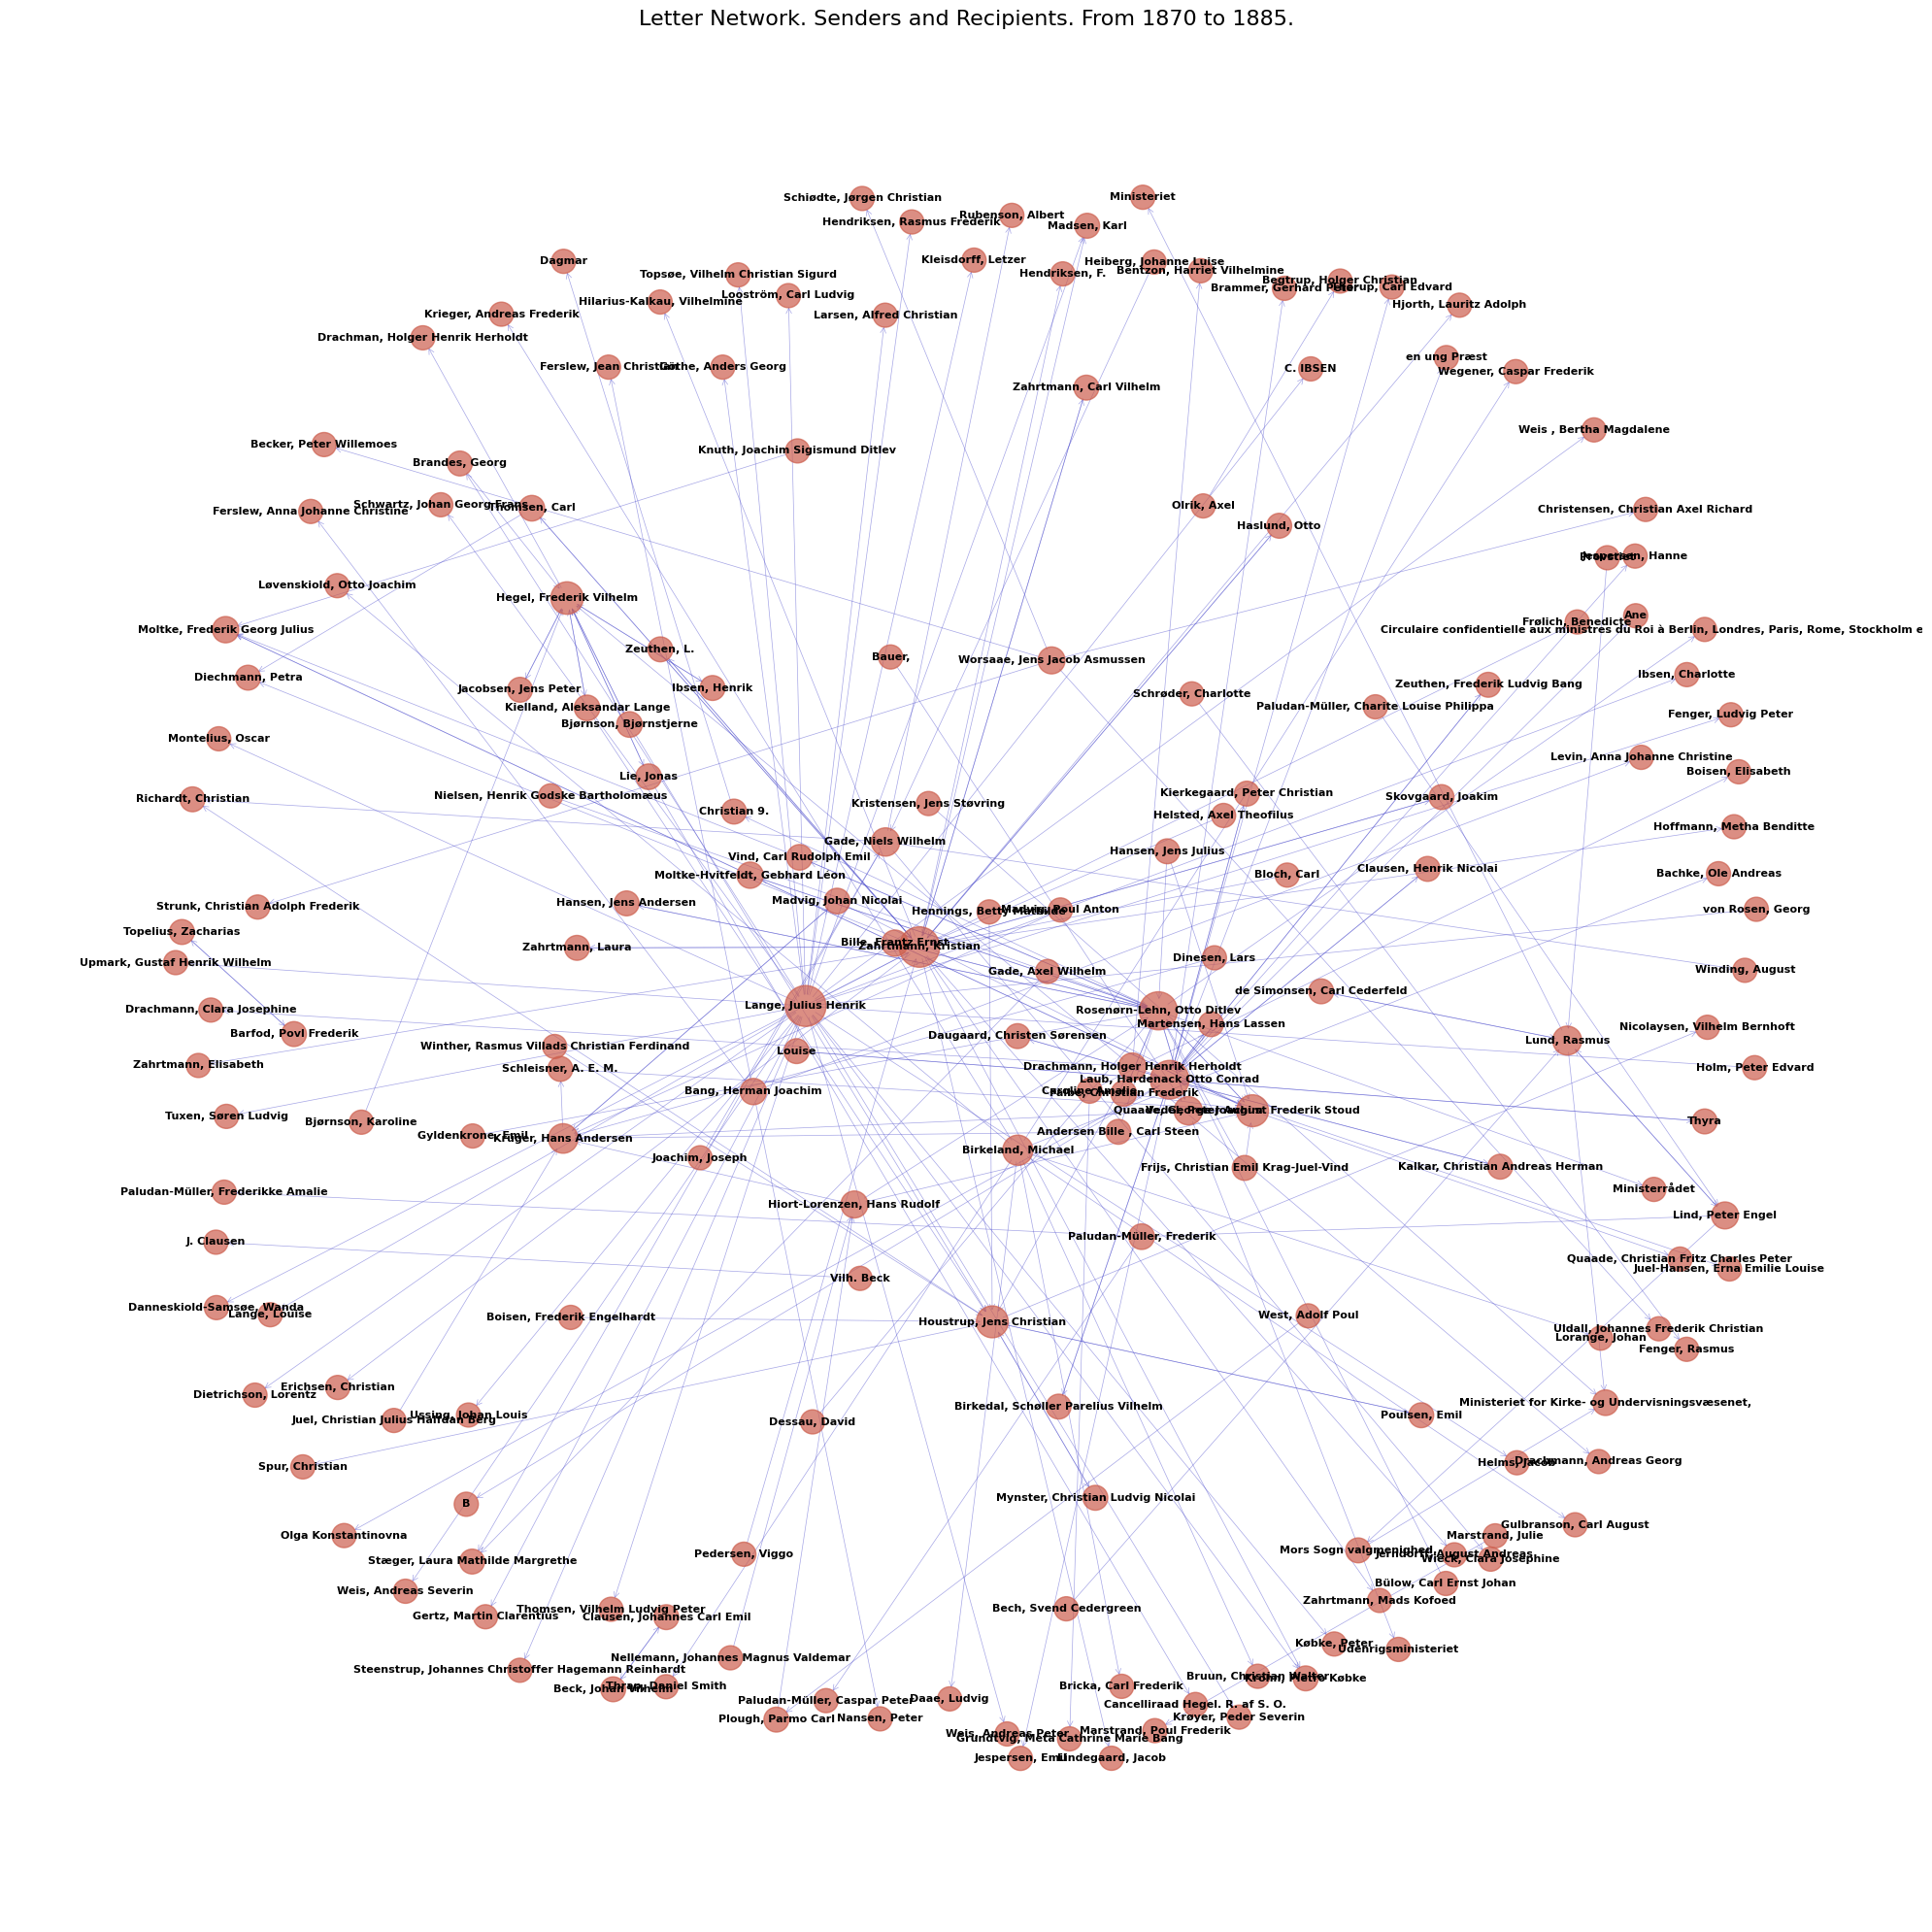

In [9]:
# Visualize the full network (this might be dense)
plt.figure(figsize=(20, 20))

# Use spring layout for visualization
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Draw nodes sized by total degree (in + out)
node_sizes = [300 + (G.in_degree(node) + G.out_degree(node)) * 20 for node in G.nodes()]

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#cd5f4e', alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color='#4e4ecd', alpha=0.5, arrows=True, 
                        arrowsize=10, arrowstyle='->', width=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title(f'Letter Network. Senders and Recipients. From {_from} to {_to}.', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


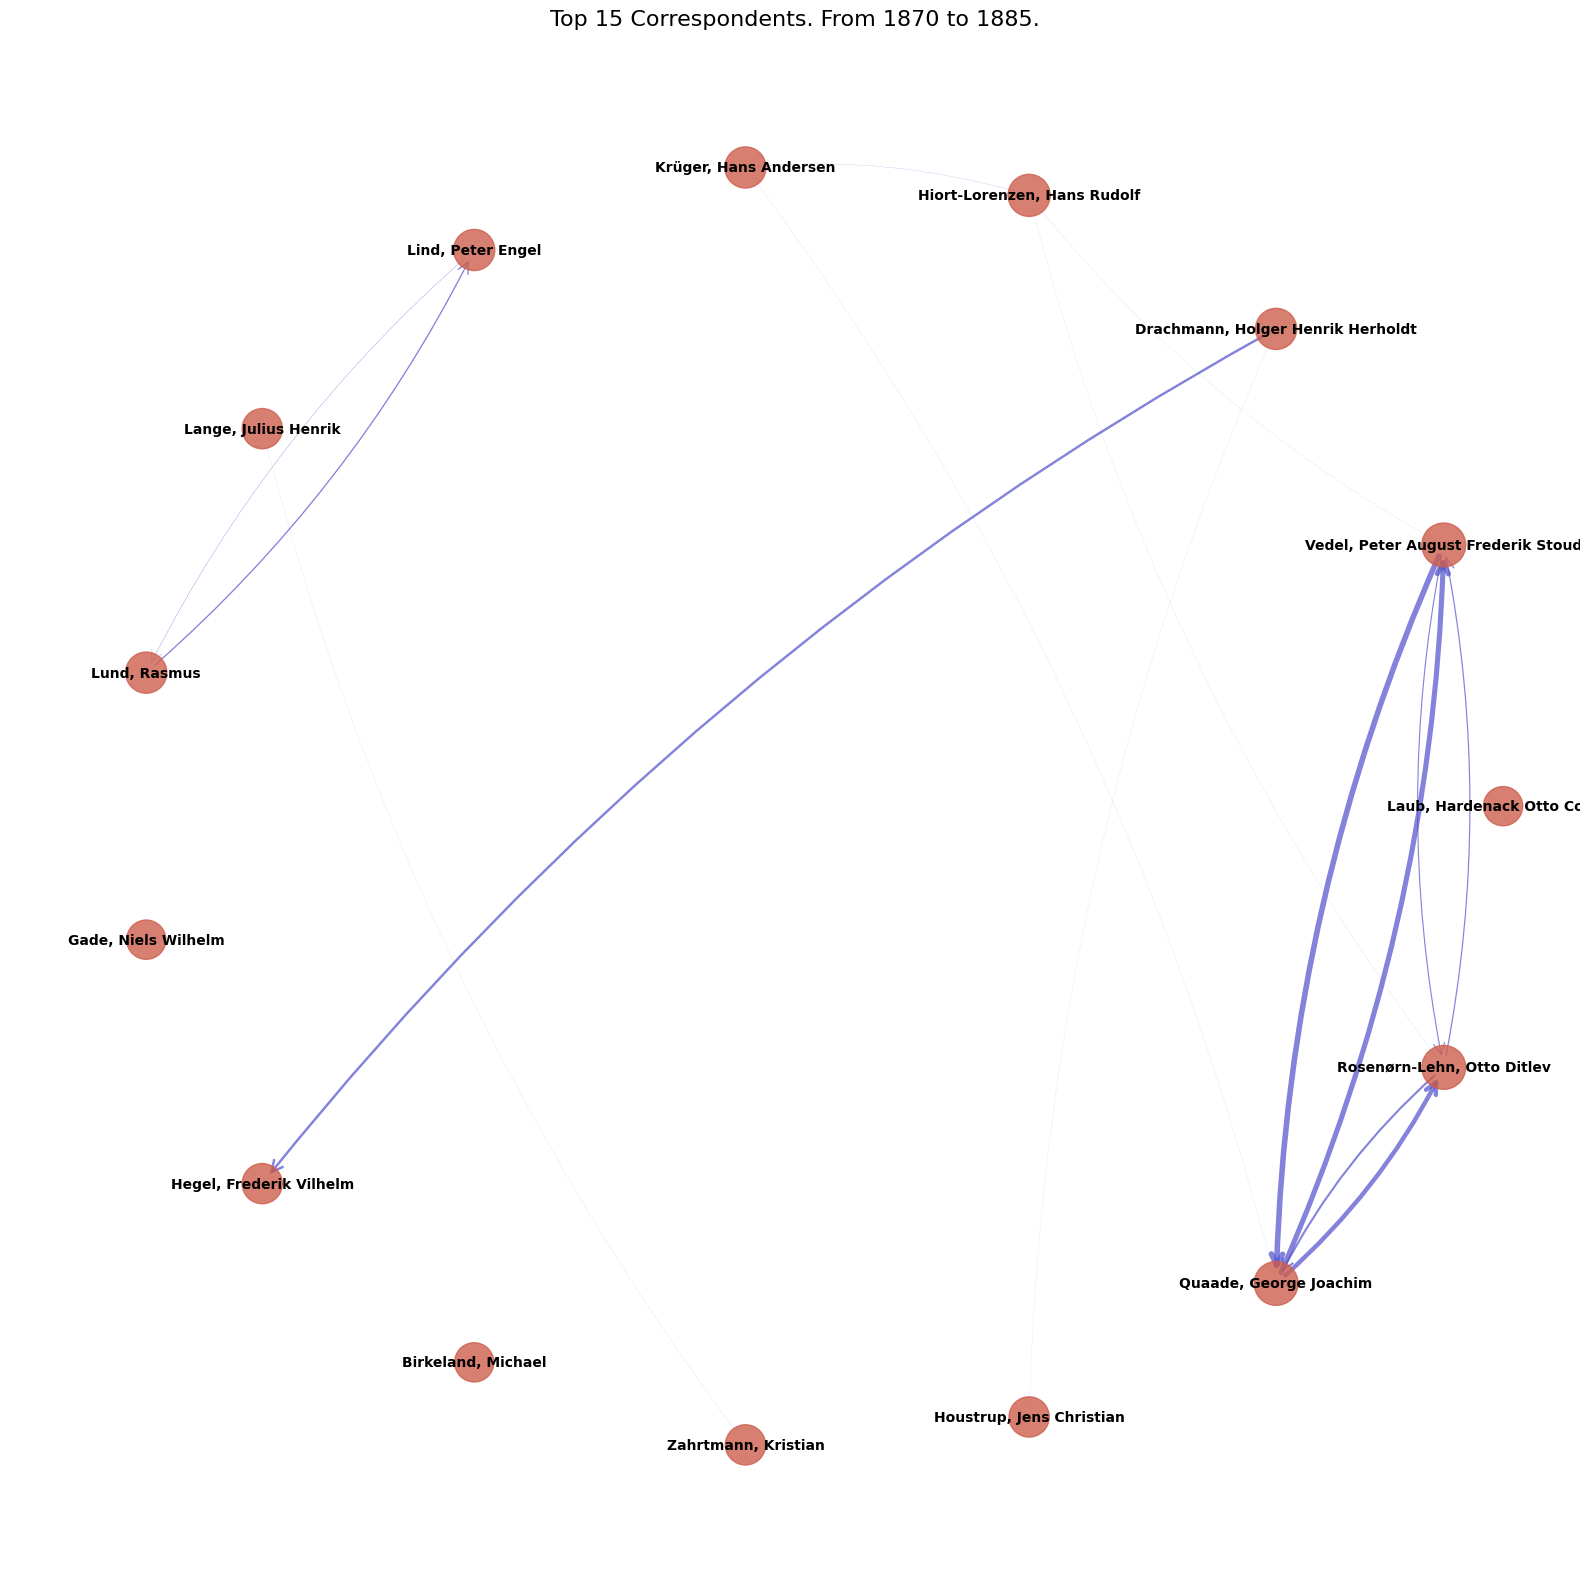

In [10]:
# Alternative visualization: Circular layout for top correspondents
top_n = 15
top_nodes_by_degree = sorted(G.nodes(), key=lambda x: G.in_degree(x) + G.out_degree(x), reverse=True)[:top_n]
G_top = G.subgraph(top_nodes_by_degree).copy()

plt.figure(figsize=(16, 16))

# Use circular layout
pos = nx.circular_layout(G_top)

# Node sizes
node_sizes = [800 + (G_top.in_degree(node) + G_top.out_degree(node)) * 40 for node in G_top.nodes()]

# Edge weights
edge_weights = [G_top[u][v]['weight'] for u, v in G_top.edges()]
max_weight = max(edge_weights) if edge_weights else 1

# Draw
nx.draw_networkx_nodes(G_top, pos, node_size=node_sizes, node_color='#cd5f4e', alpha=0.8)
nx.draw_networkx_edges(G_top, pos, edge_color='#4e4ecd', alpha=0.7, 
                        arrows=True, arrowsize=20, arrowstyle='->', 
                        width=[w/max_weight*4 for w in edge_weights],
                        connectionstyle='arc3,rad=0.1')  # Curved edges
nx.draw_networkx_labels(G_top, pos, font_size=10, font_weight='bold')

plt.title(f'Top {top_n} Correspondents. From {_from} to {_to}.', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


## What did they write about? TF–IDF with scikit-learn

We regroup letters by the top senders, assemble their combined texts, and apply `TfidfVectorizer` to surface the 15 most distinctive terms for each author. The resulting table spotlights vocabulary that sets the busiest correspondents apart within the chosen period.

In [11]:
# Subset the dataframe again to include only top senders
top_senders_df = dk_letters_subset[dk_letters_subset['sender_st'].isin(top_nodes_by_degree)]

# 
# Combine all letters per sender to prepare TF-IDF input
_top_senders_df = top_senders_df.groupby('sender_st')['text_st'].agg(' '.join).reset_index()

In [12]:
# TF-IDF analysis: top 15 distinctive words per sender
texts = _top_senders_df['text_st'].fillna('')

with open('danish_stopwords_18_19_20c.txt') as f:
    _danish_stopwords = f.read().split('\n')
danish_stopwords = [i.strip() for i in _danish_stopwords]

vectorizer = TfidfVectorizer(
    stop_words=danish_stopwords,
    max_df=0.85,
    min_df=1,
    ngram_range=(1, 1),
    sublinear_tf=True
)

tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

rows = []
for idx, sender in enumerate(_top_senders_df['sender_st']):
    row = tfidf_matrix[idx]
    if row.nnz == 0:
        top_indices = []
    else:
        coo = row.tocoo()
        order = coo.data.argsort()[::-1]
        top_indices = coo.col[order][:15]

    top_words = [feature_names[i] for i in top_indices]
    while len(top_words) < 15:
        top_words.append(None)

    row_dict = {'sender_st': sender}
    for rank, word in enumerate(top_words, start=1):
        row_dict[f'word_{rank:02d}'] = word
    rows.append(row_dict)

sender_tfidf_top_words = pd.DataFrame(rows)
sender_tfidf_top_words

sender_st       word_01      word_02  \
0                   Birkeland, Michael     birkeland  rigsarkivet   
1    Drachmann, Holger Henrik Herholdt          emmy       holger   
2                  Gade, Niels Wilhelm          dryp          rée   
3              Hegel, Frederik Vilhelm   boghandlere        hegel   
4          Hiort-Lorenzen, Hans Rudolf         hiort     lorenzen   
5             Houstrup, Jens Christian       hostrup     hillerød   
6                Krüger, Hans Andersen   nordslesvig  høimodighed   
7                 Lange, Julius Henrik          kære   kleisdorff   
8          Laub, Hardenack Otto Conrad          laub       viborg   
9                    Lind, Peter Engel     biskoppen       alters   
10                        Lund, Rasmus      nadveren    biskoppen   
11              Quaade, George Joachim        quaade      gesandt   
12          Rosenørn-Lehn, Otto Ditlev  rosenørnlehn    directeur   
13  Vedel, Peter August Frederik Stoud       quaades        vedel   
14                 Zahrtmann, Kristian        civita      dantino   

           word_03         word_04            word_05           word_06  \
0          arkivet            bibl              kongl              daae   
1             kære       drachmann          derhjemme             nuvel   
2         rubenson             und               gade          sinfonie   
3          collett         honorar                lie          hilsener   
4              als          krüger           bismarck           keudell   
5          mynster          rønnov            hatting               eva   
6         revision      elsasserne              menig           ahlmann   
7             weis     dietrichson                jul             kbhvn   
8         christen            juul  grundtvigianismen             ethik   
9   valgmenigheden      absolution        skriftemaal        forladelse   
10       altergang  konfirmationen     folkekirkelige     skriftemaalet   
11            herr          kaiser        excellences  statssecretairen   
12             ges         gesandt      pragerfredens           depeche   
13          quaade         gesandt            decazes       kammerherre   
14            malt         leonora             skøndt            amalfi   

           word_07           word_08          word_09       word_10  \
0             1613             bruun      storthinget       arkiver   
1       vilhelmine         literatur          familje       holgers   
2         richardt            maries          winding         hobro   
3         handelen          bjørnson            ibsen  manuskriptet   
4         regering          preussen  statsministeren       drøftet   
5        grundtvig               din         mynsters       poulsen   
6   nordslesvigere            lempet           quaade     tydskerne   
7           aarhus             lübke           madrid        bonnat   
8          mynster          christus             huus     martensen   
9        syndernes        sakramente      folkekirken          lund   
10  højærværdighed       skriftemaal     nadverbordet      provsten   
11      omhandlede             vedel           vedels      kaiseren   
12        regering  udenrigsminister              dmk    slesvigske   
13      heydebrand               sml         kriegers      regering   
14       christina             athen             sora     jerndorff   

           word_11      word_12       word_13           word_14  \
0             verk   throndhjem          1660          assessor   
1    idetheletaget  justitsraad  cancelliraad          kommende   
2           judith        niels            im               wir   
3         forlægge      udsolgt         arket             oplag   
4      sønderrives         hund  weserzeitung             tabes   
5     prokuratoren   nicolaysen      digtning          hennings   
6        tydskland  gengivelsen      vælgeres         tjenesten   
7      thorvaldsen    akademiet          gøre     

## Other studies

The dataset invites several complementary lines of inquiry beyond the current network and TF–IDF exploration:

- Compare the TF–IDF signatures with known biographical information about the letter writers to assess whether distinctive vocabulary aligns with documented interests or roles.
- Select alternative cohorts of correspondents (e.g. minor figures, female authors, specific professions) and examine whether their lexical profiles differ from the initial top senders.
- Investigate structural features such as average letter length per sender or per decade to see who writes longer or more concise messages.
- Experiment with sentiment or emotion analysis to gauge tone shifts across time, geography, or correspondent pairs.
- Map the geographic distribution of letters using `geo_name_st` to identify regional hubs, travel patterns, or networks of influence.

